# Siamese Network Model Training

### Install packages

In [1]:
import os
HOME = os.path.split(os.getcwd())[0]
print(HOME)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

c:\Users\arihs\Documents\Thesis\CowId


In [2]:
# %cd {HOME}

# !python -m pip install opencv-python matplotlib tensorflow==2.10 

In [3]:
# !conda install -c conda-forge cudatoolkit=11.8.0 --yes

In [4]:
# !pip install nvidia-cudnn-cu11==8.6.0.163 --yes

In [5]:
!CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib

'CUDNN_PATH' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'export' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [6]:
!python -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

tf.Tensor(314.99976, shape=(), dtype=float32)


2023-04-03 22:59:54.842195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 22:59:55.154316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9392 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Import dependencies

In [8]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
tf.config.run_functions_eagerly(True)

#### Set GPU growth

In [9]:
# To avoid OOM error
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Set folder structures

In [10]:
# Setup paths
POS_PATH = os.path.join('siamese', 'positive')
NEG_PATH = os.path.join('siamese', 'negative')
ANC_PATH = os.path.join('siamese', 'anchor')

### Data augmentation

In [11]:
def data_aug(img, quantity):
    data = []
    for i in range(quantity):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=80, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.8,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
        data.append(img)
    return data

In [12]:
import uuid

# Do the data augmentation to POS and ANC

def create_augmentation(path, quantity):
    for file_name in os.listdir(os.path.join(path)):
        img_path = os.path.join(path, file_name)
        img = cv2.imread(img_path)
        augmented_images = data_aug(img, quantity) 
        
        for image in augmented_images:
            cv2.imwrite(os.path.join(path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [13]:
# create_augmentation(POS_PATH, 20)
# create_augmentation(ANC_PATH, 20)
# # We don't need to augment negative ones, but it's good to chance the distribution a little bit
# create_augmentation(NEG_PATH, 5)

### Load and preprocess Images

In [14]:
# Create lists that can be iterated over

anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(1500)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(1500)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(1500)

In [15]:
# Create a numpy version of the file, with color values less than 1

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

### Create dataset

In [16]:
# Zipping the dataset with the matching labels

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()

In [18]:
match_example = samples.next()
match_example

(b'siamese\\anchor\\531f3855-d1a2-11ed-92ee-e848b8c82000.jpg',
 b'siamese\\positive\\c470abe7-d280-11ed-933a-e848b8c82000.jpg',
 1.0)

### Split train and test sets

In [19]:
def preprocess_double(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_double(*match_example)

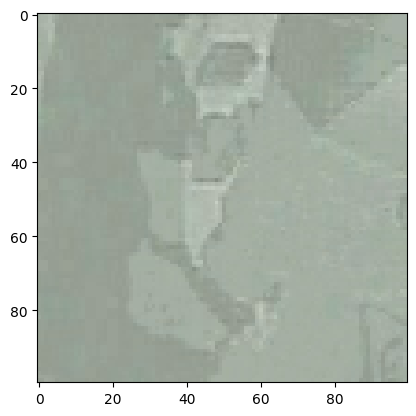

In [21]:
plt.imshow(res[1])

Build dataloader pipeline

In [22]:
# Pipeline that takes the function, caches the images and shuffles the dataset

data = data.map(preprocess_double)
data = data.cache()
data = data.shuffle(buffer_size=10000)

c:\Users\arihs\Documents\Thesis\.conda\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [23]:
samples = data.as_numpy_iterator()

In [24]:
samples.next()

(array([[[0.47941175, 0.53039217, 0.49509802],
         [0.4735294 , 0.5156863 , 0.48431373],
         [0.4745098 , 0.50490195, 0.4764706 ],
         ...,
         [0.28431374, 0.29607844, 0.26078433],
         [0.2887255 , 0.3004902 , 0.26519608],
         [0.30392158, 0.3156863 , 0.28039217]],
 
        [[0.48137254, 0.5245098 , 0.49313724],
         [0.47745097, 0.51960784, 0.4882353 ],
         [0.48137254, 0.5117647 , 0.48333332],
         ...,
         [0.28014705, 0.29191175, 0.25661764],
         [0.29093137, 0.30269608, 0.26740196],
         [0.3107843 , 0.32254902, 0.2872549 ]],
 
        [[0.4852941 , 0.5254902 , 0.49411765],
         [0.48259804, 0.52254903, 0.49117646],
         [0.48088235, 0.5178922 , 0.4872549 ],
         ...,
         [0.29411766, 0.30588236, 0.27058825],
         [0.2872549 , 0.2990196 , 0.2637255 ],
         [0.3245098 , 0.3362745 , 0.3009804 ]],
 
        ...,
 
        [[0.29093137, 0.30269608, 0.26740196],
         [0.2870098 , 0.2987745 , 0.26348

Validate one sample

In [25]:
sample = samples.next()

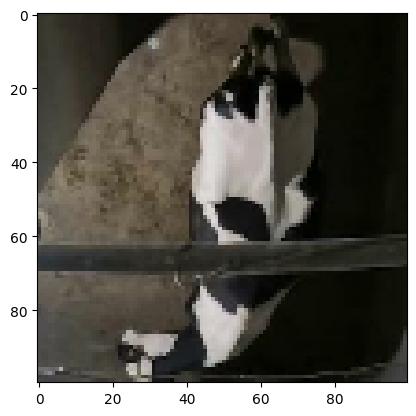

In [26]:
# First image
plt.imshow(sample[0])

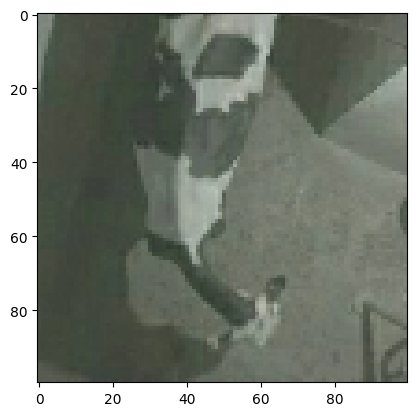

In [27]:
# Concatenated image
plt.imshow(sample[1])

In [28]:
# Relation
sample[2]

1.0

Training set

In [29]:
# Use 70% as the training set
train_data = data.take(round(len(data)*.7))
# Train it in batchs of 16
train_data = train_data.batch(16)
# Pre-process the data so the NN doesn't bottleneck
train_data = train_data.prefetch(8)

Test set

In [30]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### Model creation

Embedding Layer

In [31]:
inp = Input(shape=(100,100,3), name='input_image')

In [32]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [33]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [34]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [35]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [36]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [37]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [39]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [40]:
embedding = make_embedding()

In [41]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

Distance Layer

In [42]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [43]:
l1 = L1Dist()

### Siamese Model

In [44]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [45]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [46]:
siamese_layer = L1Dist()

In [47]:
distances = siamese_layer(inp_embedding, val_embedding)

In [48]:
classifier = Dense(1, activation='sigmoid')(distances)

In [49]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [50]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [51]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [52]:
def make_siamese_Model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_model = make_siamese_Model()

In [54]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

### Training

Loss and Optimizer

In [55]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [56]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

Establish Checkpoints

In [57]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

Train Step Function

In [58]:
test_batch = train_data.as_numpy_iterator()

In [59]:
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

Training Loop

In [60]:
from tensorflow.python.keras.metrics import Precision, Recall

In [61]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [62]:
EPOCHS = 50

In [63]:
train(train_data, EPOCHS)


 Epoch 1/50
tf.Tensor(0.69267976, shape=(), dtype=float32)
132/132 [==============================] - 30s 147ms/step
0.5709058 0.77220076 0.8385744

 Epoch 2/50
tf.Tensor(0.3949874, shape=(), dtype=float32)
132/132 [==============================] - 19s 145ms/step
0.1334919 0.874053 0.89524734

 Epoch 3/50
tf.Tensor(0.21524575, shape=(), dtype=float32)
132/132 [==============================] - 19s 144ms/step
0.105499536 0.913085 0.913085

 Epoch 4/50
tf.Tensor(0.47070697, shape=(), dtype=float32)
132/132 [==============================] - 19s 144ms/step
0.3700266 0.9327651 0.9292453

 Epoch 5/50
tf.Tensor(0.054372676, shape=(), dtype=float32)
132/132 [==============================] - 19s 143ms/step
0.51854795 0.95845413 0.94476193

 Epoch 6/50
tf.Tensor(0.41795376, shape=(), dtype=float32)
132/132 [==============================] - 19s 140ms/step
0.36656588 0.95420563 0.9480037

 Epoch 7/50
tf.Tensor(0.06562065, shape=(), dtype=float32)
132/132 [==============================] - 18s

### Predict

In [64]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [65]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 220ms/step


In [66]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]

In [67]:
y_true

array([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

### Calculate metrics

Creating a recall object 

In [68]:
m = Recall()

Calculating the recall value 

In [69]:
m.update_state(y_true, y_hat)

In [70]:
m.result().numpy()

1.0

Creating a precision object

In [71]:
m = Precision()

Calculating the precision value

In [72]:
m.update_state(y_true, y_hat)

In [73]:
m.result().numpy()

1.0

In [74]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 18ms/step
1.0 1.0


### Results validation

Same


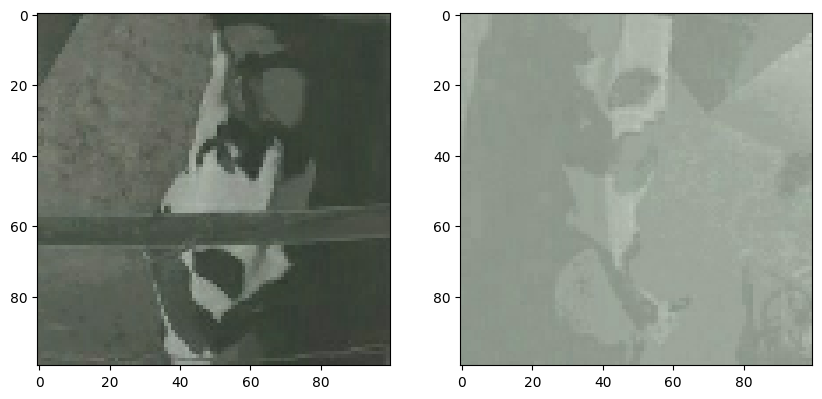

In [80]:
SAMPLE_NUMBER = 3

# Print label
if y_true[SAMPLE_NUMBER] == 0.0:
    print("Different")
else: 
    print("Same")

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[SAMPLE_NUMBER])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[SAMPLE_NUMBER])

# Renders cleanly
plt.show()

### Save model

In [76]:
siamese_model.save('siamesemodelv2.h5')

In [ ]:
L1Dist

In [ ]:
siamese_model = Models.load_Model('siamesemodelv3.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':BinaryCrossentropy})

In [ ]:
siamese_model.predict([test_input, test_val])

In [ ]:
siamese_model.summary()